In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
import warnings

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing 

In [2]:
# setup computing
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [6]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# define paths
repo_path = Path('git/tree-finder/')
full_repo_path = Path('/content/drive/My Drive ') / repo_path
model_path = full_repo_path / 'models'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(repo_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings
from notebooks.train_fns import flatten, Flatten, train_model
from notebooks.models import ResnetBinClassifier

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

In [8]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [9]:
# make dataset
SCALE = 1024
CROP = SCALE
SCALE_TEMP = 224 # for training

# define transformations
# normalization per pytorch documentation for pretrained models
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tnorm = T.Normalize(mean, std)
transforms = {}
transforms['orig'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor(), tnorm])
transforms['mirr'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), T.RandomHorizontalFlip(1), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor(), tnorm])

# include a random cropping (flipped and unflipped) at three crop sizes
for pct in [10, 25, 50]:
    scale_param = int(1 / (pct*0.01))
    transforms[f'crop{pct}'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                          T.Resize(SCALE_TEMP),
                                          T.ToTensor(), tnorm])
    transforms[f'crop{pct}_mirr'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                               T.RandomHorizontalFlip(1),
                                               T.Resize(SCALE_TEMP),
                                               T.ToTensor(), tnorm])

In [10]:
# create dataset by concatenating all transformations
binds = []
for t in transforms:
    df = dset.ImageFolder(root= full_repo_path / 'data/images_bin', transform=transforms[t])
    binds.append(df)

binds = ConcatDataset(binds)
class_names = binds.datasets[0].classes
print(class_names)

In [11]:
# make dataloaders
PCT_TRAIN, PCT_VAL = 0.75, 0.15
N = len(binds)
ds_sizes = {'all': N,
            'train': int(N * PCT_TRAIN),
            'validate': int(N * PCT_VAL),
            'test': N - int(N * (PCT_TRAIN + PCT_VAL))}
print(ds_sizes)


# make loaders
dataloaders = {}
dataloaders['all'] = DataLoader(dataset=binds, batch_size=N, shuffle=False)
dataloaders['train'] = DataLoader(binds, batch_size=32,
                           sampler=sampler.SubsetRandomSampler(range(ds_sizes['train'])))
dataloaders['validate'] = DataLoader(binds, batch_size=32,
                           sampler=sampler.SubsetRandomSampler(range(ds_sizes['train'], ds_sizes['train']+ds_sizes['validate'])))
dataloaders['test'] = DataLoader(binds, batch_size=32,
                           sampler=sampler.SubsetRandomSampler(range(ds_sizes['train']+ds_sizes['validate'], N)))

{'all': 3136, 'train': 2352, 'validate': 470, 'test': 314}


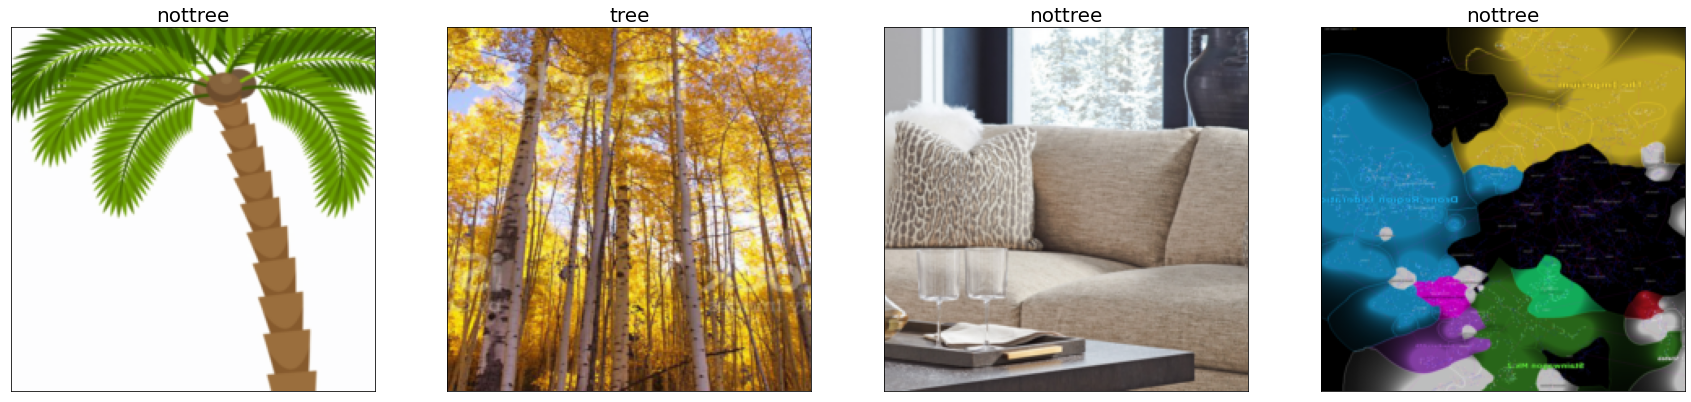

In [12]:
# visualize images
loader_samp = DataLoader(dataset=binds, batch_size=4, shuffle=True)
samp_input, samp_class = next(iter(loader_samp))

# print(type(imgs), type(labels))
show_image_batch(samp_input, mean=np.array(mean), std=np.array(std), 
                 title=[class_names[x] for x in samp_class])

# Retrain a pretrained model for binary classification of trees

## Overfit on small data

In [13]:
small_data_size = 100
small_batch_size = 20
small_loaders = {}
small_loaders['train'] = DataLoader(binds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(range(small_data_size)))
small_loaders['validate'] = DataLoader(binds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(range(small_data_size, small_data_size*2)))
small_ds_sizes = {'train':small_data_size, 'validate':small_data_size}

In [14]:
model = ResnetBinClassifier(resnet50=True)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

loading pretrained resnet50...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


In [24]:
model, acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                                   small_loaders, small_ds_sizes, device, 3)

# torch.save(model.state_dict(), model_path / 'ResnetBinClassifier.pt')

train epoch: [0/3] Loss: 0.2680 ACC@1: 100.00%: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
validate epoch: [0/3] Loss: 0.1402 ACC@1: 100.00%:  80%|████████  | 4/5 [00:07<00:01,  1.85s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
validate epoch: [0/3] Loss: 0.1391 ACC@1: 100.00%: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
train epoch: [1/3] Loss: 0.0812 ACC@1: 100.00%: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
validate epoch: [1/3] Loss: 0.0410 ACC@1: 100.00%: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]
train epoch: [2/3] Loss: 0.0282 ACC@1: 100.00%: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
validate epoch: [2/3] Loss: 0.0154 ACC@1: 100.00%: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]

Returning best model, with validation accuracy 1.0


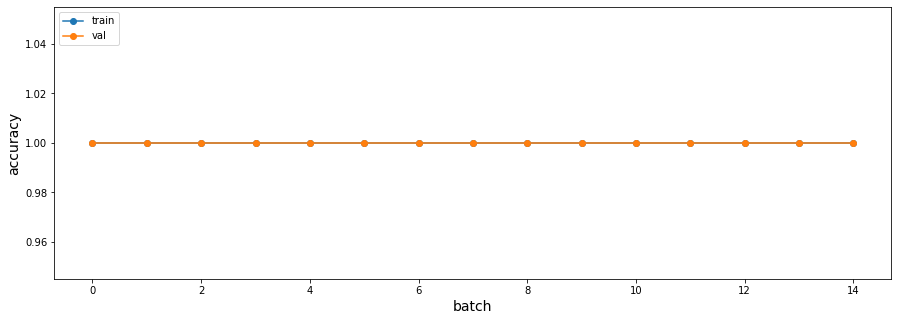

In [25]:
plt.subplots(figsize=(15, 5))
plt.plot(acc_history['train'], '-o')
plt.plot(acc_history['validate'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

## Train using entire dataset

In [ ]:
model = ResnetBinClassifier(resnet50=True)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model, acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                                   dataloaders, ds_sizes, device, 1)

torch.save(model.state_dict(), model_path / 'ResnetBinClassifier.pt')

loading pretrained resnet50...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


train epoch: [0/1] Loss: 0.6571 ACC@1: 73.44%:   3%|▎         | 2/74 [00:50<30:06, 25.09s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
train epoch: [0/1] Loss: 0.3025 ACC@1: 87.24%: 100%|██████████| 74/74 [26:01<00:00, 21.10s/it]
validate epoch: [0/1] Loss: 0.1174 ACC@1: 97.60%:  87%|████████▋ | 13/15 [01:03<00:09,  4.67s/it]

In [ ]:
plt.subplots(figsize=(15, 5))
plt.plot(acc_history['train'], '-o')
plt.plot(acc_history['validate'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'rerun pretrained model'
!git push